# Word2Vec on Novels Corpus

DS 5001 Text as Data

**Purpose:** We create word embeddings with novel data using word2vec and visualize results with tSNE.

# Set Up

In [55]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [56]:
# Adjust this for a new corpus
data_prefix = 'novels'
table_dir =  f'{data_home}/{data_prefix}'
OHCO = ['book', 'chapter', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:4] # Paragraphs
SENT = OHCO[:5] # Sentences
BAG = PARA

In [57]:
# word2vec parameters
w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [58]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne
import plotly_express as px

In [59]:
import gensim
gensim.__version__

'4.3.3'

# Import `TOKENS` and `VOCAB`

We import data from the TOKEN table of the novels corpus, excluding proper nouns.

In [60]:
TOKENS = pd.read_csv(f'{table_dir}/{data_prefix}-TOKENS.csv').set_index(OHCO)

In [61]:
TOKENS.head()

pos     term_str  term_id
book            chapter para_num sent_num token_num                           
secretadversary 1       0        1        0           DT          the    24127
                                          1          NNP        young    27354
                                          2          NNP  adventurers      399
                                          3          NNP          ltd    14406
                        1        0        0           JJ        tommy    24529

In [62]:
VOCAB = pd.read_csv(f'{table_dir}/{data_prefix}-VOCAB.csv').set_index('term_str')

In [63]:
VOCAB = VOCAB[~VOCAB.index.isna()] # There is NaN in the index for some reason

In [64]:
VOCAB.sample(5)

,term_id,n,p,port_stem,stop,df,idf,tfidf_sum,tfidf_mean,tfidf_max,pos_max
term_str,,,,,,,,,,,
chiefest,3945,1,6.664814e-07,chiefest,0,1,2.50515,2.50515,0.007829,2.50515,JJS
nestled,16047,1,6.664814e-07,nestl,0,1,2.50515,2.50515,0.007829,2.50515,VBD
mediasch,14976,1,6.664814e-07,mediasch,0,1,2.50515,2.50515,0.007829,2.50515,NNP
buckled,3071,1,6.664814e-07,buckl,0,1,2.50515,2.50515,0.007829,2.50515,VBD
stationing,22848,1,6.664814e-07,station,0,1,2.50515,2.50515,0.007829,2.50515,VBG


In [65]:
VOCAB['pos_max'] = TOKENS.groupby(['term_str','pos']).pos.count().unstack().idxmax(axis=1)

In [66]:
VOCAB

,term_id,n,p,port_stem,stop,df,idf,tfidf_sum,tfidf_mean,tfidf_max,pos_max
term_str,,,,,,,,,,,
a,0,28533,1.901671e-02,a,1,320,0.000000,0.000000,0.000000,0.000000,DT
aback,1,9,5.998332e-06,aback,0,9,1.550907,13.958167,0.043619,1.550907,NN
abaft,2,2,1.332963e-06,abaft,0,1,2.505150,5.010300,0.015657,5.010300,IN
abandon,3,44,2.932518e-05,abandon,0,28,1.057992,46.551646,0.145474,6.347952,VB
abandoned,4,68,4.532073e-05,abandon,0,43,0.871682,59.274344,0.185232,6.101771,VBN
...,...,...,...,...,...,...,...,...,...,...,...
à,27392,3,1.999444e-06,à,0,3,2.028029,6.084086,0.019013,2.028029,NNP
æt,27393,1,6.664814e-07,æt,0,1,2.505150,2.505150,0.007829,2.505150,NN
ætat,27394,1,6.664814e-07,ætat,0,1,2.505150,2.505150,0.007829,2.505150,VBD


# Convert to Gensim

We now create a Gensim-style corpus of docs, a list of lists of tokens.

In [67]:
# TOKENS

In [68]:
docs = TOKENS[~TOKENS.pos.str.match('NNPS?')].dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs

In [69]:
print(docs[:2])

[['to', 'she', 'is', 'always', 'woman'], ['i', 'have', 'seldom', 'heard', 'him', 'mention', 'her', 'under', 'any', 'other', 'name']]


In [70]:
vocab = Dictionary(docs)

# Generate word embeddings with Gensim's module

In [71]:
model = word2vec.Word2Vec(docs, **w2v_params)

In [72]:
model.wv.vectors

array([[ 0.03612265, -0.46581137,  0.33278853, ...,  0.25356713,
        -0.30074704, -0.5094161 ],
       [ 0.3302362 , -0.98440564, -0.7295008 , ..., -0.28463757,
         0.64015514, -0.05161305],
       [-0.5884588 , -0.43573374,  0.15174137, ..., -0.29023236,
         0.83890283, -0.45170316],
       ...,
       [-0.0095797 ,  0.01697527, -0.04394706, ..., -0.02861191,
        -0.04819743, -0.03370686],
       [ 0.1250028 , -0.03795966, -0.08854634, ..., -0.1042401 ,
        -0.00438907, -0.05955844],
       [ 0.07774031, -0.03664799, -0.05391048, ..., -0.03654962,
        -0.02829099, -0.00596429]], dtype=float32)

# Visualize with tSNE

## Convert model to data frame

In [73]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [74]:
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [75]:
WV

,0,1,2,3,4,5,6,7,8,9,...,236,237,238,239,240,241,242,243,244,245
term_str,,,,,,,,,,,,,,,,,,,,,
a,-0.592304,-0.378277,0.178882,1.219893,-0.613832,-0.068017,-0.086648,-0.376586,0.320077,0.261932,...,-0.378289,0.550629,-0.129071,0.471804,-0.038352,-0.130952,0.096916,0.408432,-0.286647,-0.324279
abandoned,-0.026419,-0.134994,0.048969,0.014863,-0.083896,-0.002670,-0.136173,-0.111587,-0.064221,-0.091737,...,-0.049146,0.048621,-0.057040,-0.075610,0.166560,0.038642,0.048501,-0.023162,-0.015211,-0.079484
abbess,-0.029165,-0.060336,-0.059855,0.058834,-0.058082,-0.053828,-0.176020,-0.093627,0.079994,0.034164,...,0.059408,-0.052322,0.038555,0.043925,0.040391,0.112939,0.007377,-0.033180,0.083521,-0.003463
able,0.338904,-0.348439,-0.188265,-0.284022,0.315528,0.150214,-0.080612,-0.024742,-0.118932,0.281609,...,-0.266336,1.072374,-0.193254,0.106401,0.223860,-0.382491,-0.035124,0.296877,-0.435373,-0.457831
about,-0.733192,0.129062,0.026123,0.344310,0.304902,-0.176085,-0.195174,-0.360658,-0.536439,0.576155,...,0.418863,-0.882096,-0.513408,-0.835578,-0.079036,-0.101341,0.084801,-0.145730,0.107216,0.488483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youre,0.140547,0.183734,-0.169218,0.044421,0.036596,-0.010578,-0.048556,0.214494,-0.128736,0.047695,...,0.116460,0.212945,-0.197725,0.034341,-0.343489,-0.336620,-0.087852,0.136372,-0.091617,0.350789
yours,-0.017518,-0.005871,-0.116552,0.005699,0.032257,0.039270,-0.259113,-0.087189,0.183725,0.065843,...,-0.059005,0.051473,-0.197329,0.187450,-0.146572,-0.033456,-0.095737,0.117019,-0.473564,-0.004513
yourself,0.007587,0.281784,-0.632789,-0.010081,0.471760,0.461588,-0.066995,0.396089,0.267954,-0.068467,...,0.188454,0.083547,-0.212695,0.375887,-0.393579,-0.097657,-0.328693,0.236935,-0.959486,0.239521


## Use ScikitLearn's TSNE library

In [76]:
tsne_engine = tsne(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

In [77]:
tsne_model = tsne_engine.fit_transform(WV.to_numpy())

In [78]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)

In [79]:
TSNE

,x,y
term_str,,
a,-7.419424,31.284721
abandoned,-2.097271,-18.519197
abbess,-4.781855,-3.465311
able,5.508907,-36.753670
about,23.050365,-15.928250
...,...,...
youre,21.056787,-24.807409
yours,25.355955,-0.637197
yourself,33.819775,4.314376


## Plot the coordinates

In [83]:
VOCAB['dfidf'] = VOCAB.df * VOCAB.idf

In [84]:
X = TSNE.join(VOCAB, how='left')

In [85]:
X.head()

,x,y,term_id,n,p,port_stem,stop,df,idf,tfidf_sum,tfidf_mean,tfidf_max,pos_max,dfidf
term_str,,,,,,,,,,,,,,
a,-7.419424,31.284721,0,28533,0.019017,a,1,320,0.000000,0.000000,0.000000,0.000000,DT,0.000000
abandoned,-2.097271,-18.519197,4,68,0.000045,abandon,0,43,0.871682,59.274344,0.185232,6.101771,VBN,37.482305
abbess,-4.781855,-3.465311,14,69,0.000046,abbess,0,12,1.425969,98.391843,0.307475,31.371312,NN,17.111625
able,5.508907,-36.753670,50,315,0.000210,abl,0,173,0.267104,84.137721,0.262930,1.602623,JJ,46.208970
about,23.050365,-15.928250,71,2000,0.001333,about,1,295,0.035328,70.655925,0.220800,1.377791,IN,10.421749


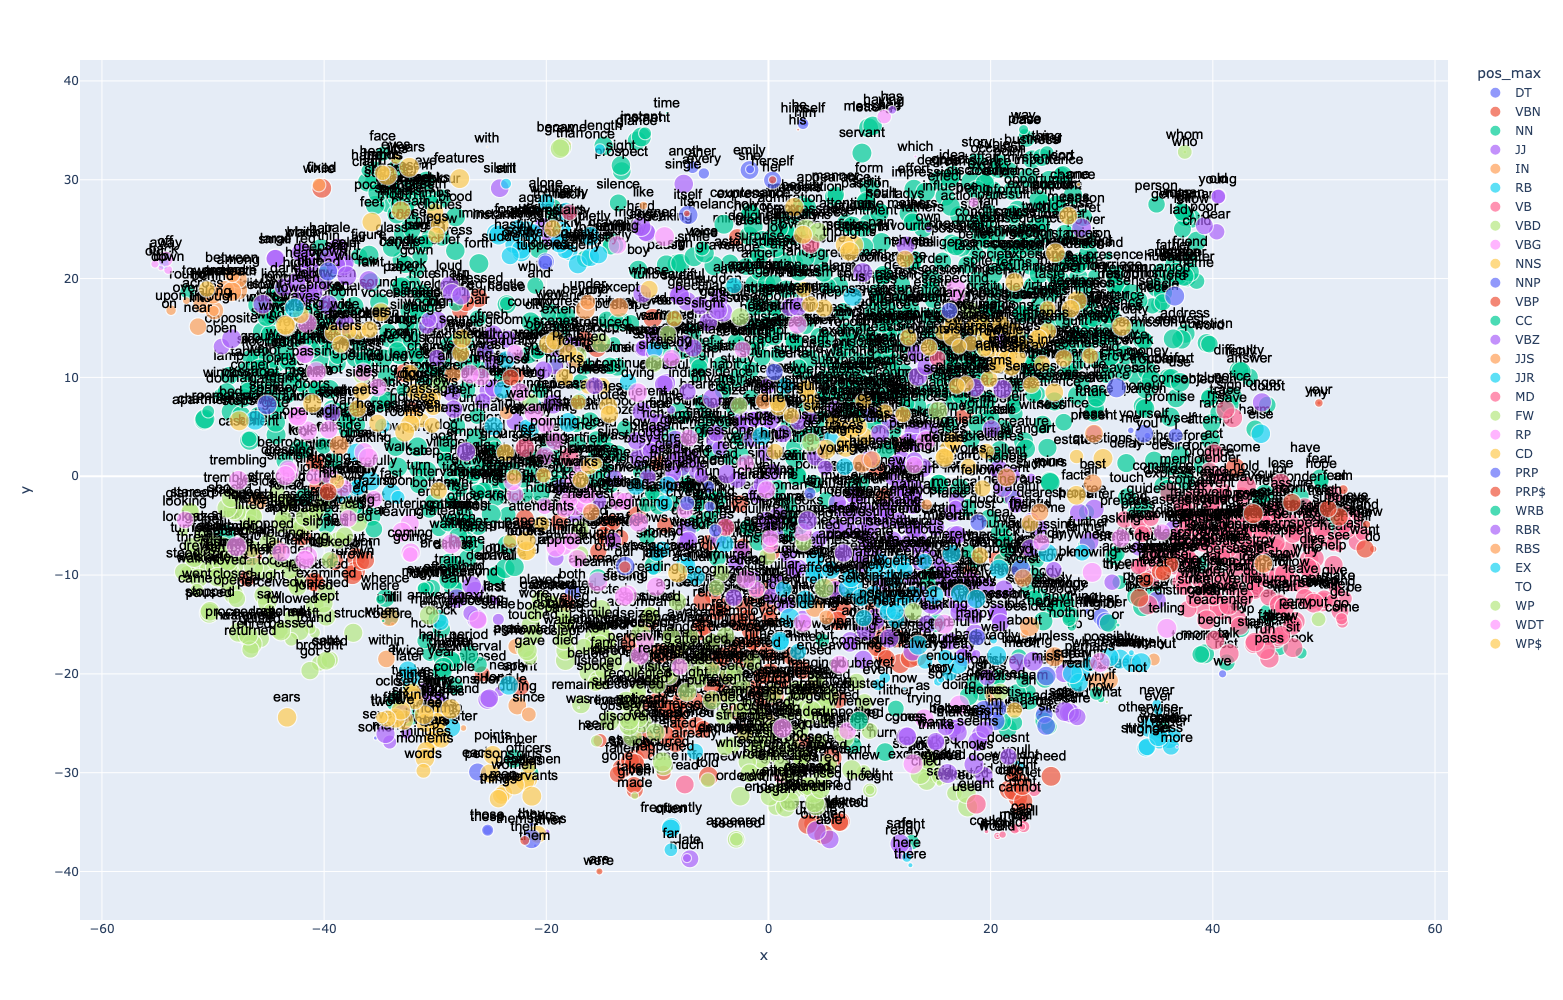

In [86]:
px.scatter(X.reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_max', 
           hover_name='term_str',          
           size='dfidf',
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Semantic Algebra

## Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [28]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [29]:
complete_analogy('man', 'boy', 'woman', 3)

,term,sim
0,girl,0.796120
1,peasant,0.740536
2,lady,0.675373


In [30]:
complete_analogy('girl', 'daughter', 'boy', 3)

,term,sim
0,uncle,0.814615
1,mistress,0.785502
2,wife,0.750105


In [31]:
complete_analogy('girl', 'sister', 'boy', 3)

,term,sim
0,uncle,0.802146
1,cousin,0.799803
2,mistress,0.782722


In [32]:
complete_analogy('man', 'gentleman', 'woman', 5)

,term,sim
0,girl,0.844896
1,lady,0.764598
2,young,0.705881
3,peasant,0.705553
4,poor,0.694227


In [33]:
complete_analogy('man', 'woman', 'gentleman', 5)

,term,sim
0,girl,0.844896
1,lady,0.764598
2,young,0.705881
3,peasant,0.705553
4,poor,0.694227


In [34]:
complete_analogy('woman', 'man', 'lady', 5)

,term,sim
0,gentleman,0.737920
1,friend,0.686543
2,fellow,0.676636
3,servant,0.662854
4,boy,0.646279


In [35]:
complete_analogy('day', 'night', 'sun', 5)

,term,sim
0,rain,0.838263
1,clouds,0.827968
2,moon,0.809443
3,wind,0.794291
4,breeze,0.791899


In [36]:
complete_analogy('woman','answered','man', 5)

,term,sim
0,replied,0.704765
1,remarked,0.687423
2,said,0.678319
3,says,0.670307
4,cried,0.655712


In [37]:
complete_analogy('man','replied','woman', 5)

,term,sim
0,answered,0.742878
1,added,0.722585
2,said,0.722163
3,exclaimed,0.717575
4,oh,0.693131


In [38]:
complete_analogy('wife', 'appeared', 'husband', 5)

,term,sim
0,seemed,0.797570
1,served,0.620150
2,considered,0.595629
3,sought,0.594818
4,believed,0.574584


In [39]:
complete_analogy('husband', 'appeared', 'wife', 5)

,term,sim
0,seemed,0.646106
1,perceived,0.624465
2,discovered,0.582727
3,distinguished,0.580765
4,concluded,0.563109


In [40]:
complete_analogy('man', 'father', 'woman', 5)

,term,sim
0,mother,0.840587
1,sister,0.803401
2,aunt,0.799118
3,husband,0.793440
4,daughter,0.760100


In [41]:
complete_analogy('man', 'husband', 'woman', 5)

,term,sim
0,mother,0.841331
1,beloved,0.775306
2,niece,0.771318
3,aunt,0.769432
4,father,0.766390


In [42]:
complete_analogy('man', 'castle', 'woman', 5)

,term,sim
0,house,0.706806
1,convent,0.696969
2,chateau,0.691001
3,church,0.652736
4,spot,0.630140


In [43]:
complete_analogy('woman', 'home', 'man', 5)

,term,sim
0,station,0.668863
1,rest,0.653924
2,lunch,0.636811
3,dinner,0.591214
4,tomorrow,0.581777


## Similarites

In [44]:
get_most_similar('joy')

,term,sim
0,horror,0.880383
1,tenderness,0.861176
2,despair,0.856844
3,terror,0.855851
4,delight,0.843799
5,admiration,0.838073
6,grief,0.830951
7,sorrow,0.830722
8,anguish,0.826529
9,emotions,0.824065


In [45]:
get_most_similar('man')

,term,sim
0,gentleman,0.837501
1,woman,0.833015
2,girl,0.771171
3,fellow,0.736207
4,person,0.687806
5,stranger,0.670989
6,peasant,0.670213
7,creature,0.669776
8,lady,0.667304
9,boy,0.655303


In [46]:
get_most_similar(positive=['man'], negative=['woman'])

,term,sim
0,watch,0.360608
1,us,0.316082
2,case,0.311257
3,ship,0.299781
4,police,0.296794
5,them,0.294765
6,paper,0.293618
7,lie,0.287053
8,bank,0.285076
9,box,0.282065


In [47]:
get_most_similar(positive='woman')

,term,sim
0,girl,0.899741
1,gentleman,0.861864
2,man,0.833016
3,fellow,0.751640
4,peasant,0.744904
5,creature,0.735183
6,lady,0.732383
7,stranger,0.712954
8,youth,0.698572
9,child,0.690557


In [48]:
get_most_similar(positive=['woman'], negative=['man'])

,term,sim
0,affected,0.457203
1,particularly,0.444250
2,sweet,0.425938
3,young,0.407211
4,impressed,0.402539
5,beloved,0.401081
6,alarmed,0.386920
7,disappointed,0.386786
8,truly,0.381195
9,excited,0.378506


In [49]:
get_most_similar(['man','woman'],['boy','girl'])

,term,sim
0,nor,0.457848
1,even,0.406290
2,doubted,0.395099
3,human,0.393473
4,person,0.382061
5,or,0.371345
6,guilty,0.370566
7,than,0.364218
8,suspected,0.358033
9,believed,0.355554


# View with HAC

In [51]:
import sys
sys.path.append(local_lib)
from hac2 import HAC

In [52]:
WV2 = WV.join(VOCAB.pos_max)
WV2 = WV2[~WV2.pos_max.str.match(r"NNPS?")].iloc[:, :-1]

<Figure size 640x480 with 0 Axes>

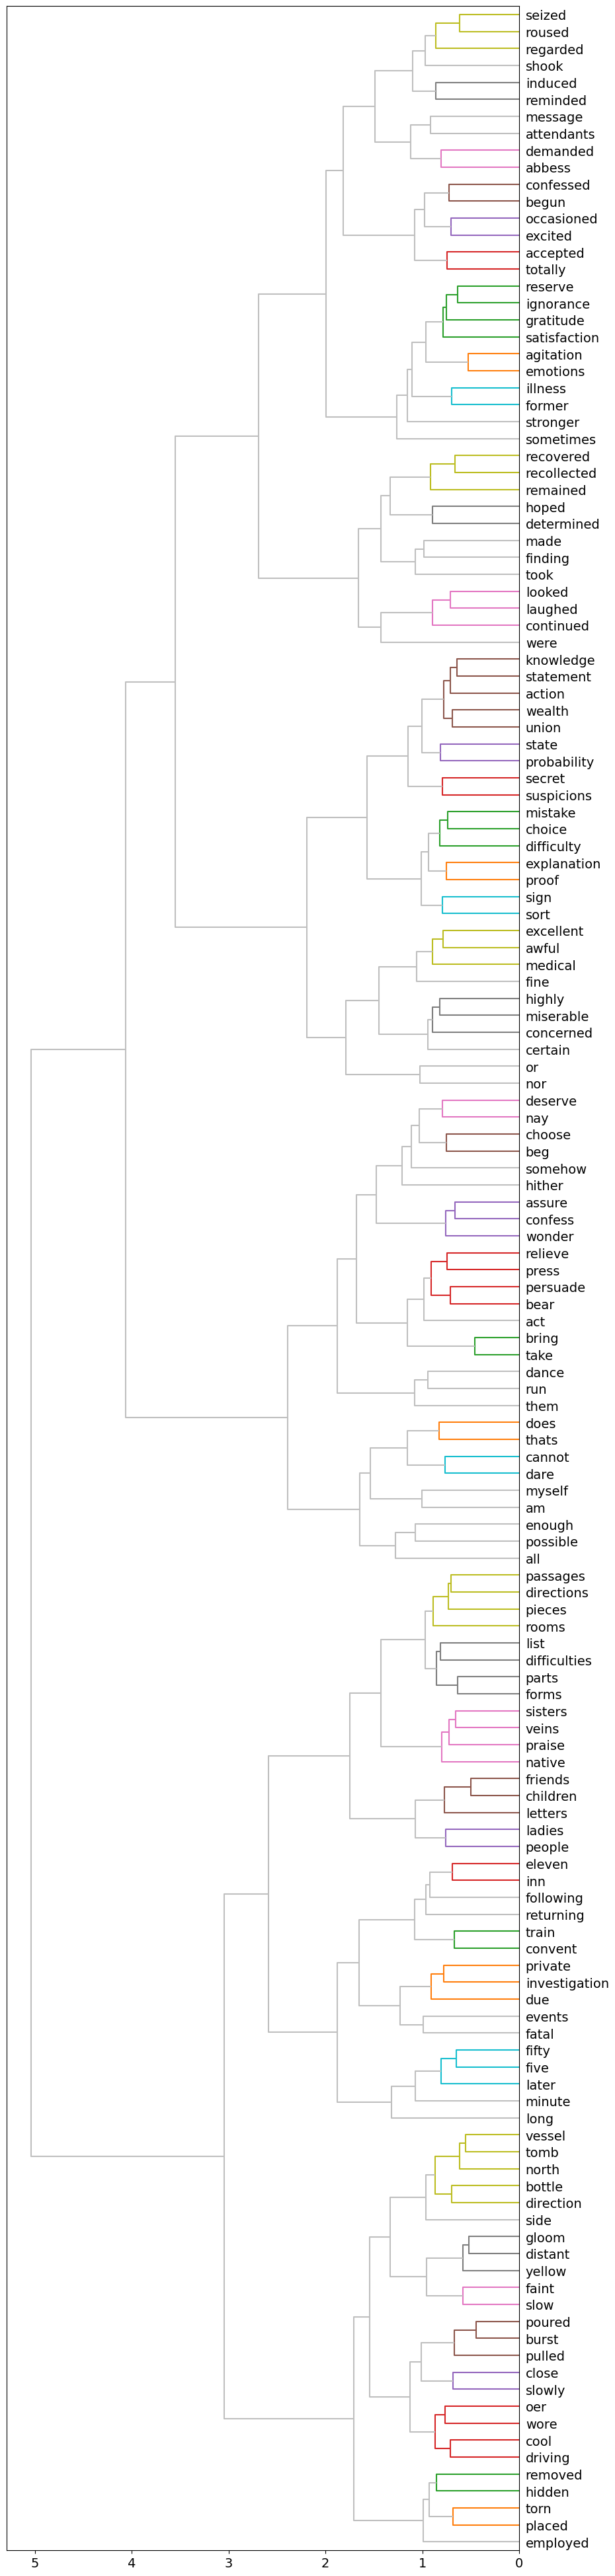

In [53]:
HAC(WV2.sample(150)).plot()

# Save

In [ ]:
# W2V = pd.DataFrame(model.wv.vectors_norm, index=model.wv.vocab.keys())
# WV.to_csv('{}/{}-W2V.csv'.format(data_out, data_prefix))
# pd.Series(DOCS).to_csv('{}/{}-GENSIM_DOCS.csv'.format(data_out, data_prefix), index=False, header=False)